In [2]:
# Notebook settings
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [3]:
# Default
import os
import urllib.request
import sys
module_path = os.path.abspath('/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/')
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np

2023-11-29 15:22:34,792 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-11-29 15:22:34,794 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


# Import data

In [4]:
maxquant_peptide = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/combined/txt/peptides.txt'

In [5]:
peptide = pd.read_csv(maxquant_peptide,
                      sep='\t')

In [6]:
peptide.columns

Index(['Sequence', 'N-term cleavage window', 'C-term cleavage window',
       'Amino acid before', 'First amino acid', 'Second amino acid',
       'Second last amino acid', 'Last amino acid', 'Amino acid after',
       'A Count', 'R Count', 'N Count', 'D Count', 'C Count', 'Q Count',
       'E Count', 'G Count', 'H Count', 'I Count', 'L Count', 'K Count',
       'M Count', 'F Count', 'P Count', 'S Count', 'T Count', 'W Count',
       'Y Count', 'V Count', 'U Count', 'O Count', 'Length',
       'Missed cleavages', 'Mass', 'Proteins', 'Leading razor protein',
       'Start position', 'End position', 'Gene names', 'Protein names',
       'Unique (Groups)', 'Unique (Proteins)', 'Charges', 'PEP', 'Score',
       'Fraction Average', 'Fraction Std. Dev.', 'Fraction 1', 'Fraction 2',
       'Fraction 3', 'Fraction 4', 'Fraction 5', 'Fraction 6', 'Fraction 7',
       'Fraction 8', 'Fraction 9', 'Fraction 10', 'Fraction 11', 'Fraction 12',
       'Fraction 13', 'Fraction 14', 'Fraction 15', 'Fra

# Generate decoy

In [7]:
from utils.tools import write_df_to_fasta
write_df_to_fasta(df=peptide,
                  id_col='id',
                  seq_col='Sequence',
                  fasta_path='/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/MQ_unique_peptide.fasta')

In [8]:
!decoypyrat -c '' -o '/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/MQ_unique_peptide_decoy.fasta' /mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/MQ_unique_peptide.fasta

proteins:44615
target peptides:44615
decoy peptides:44615
#intersection:3
0 have no alternative peptide
final decoy peptides:44615


In [21]:
from utils.tools import write_fasta_to_df
decoy = write_fasta_to_df('/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/MQ_unique_peptide_decoy.fasta')
decoy = decoy.rename('seq')
decoy = pd.DataFrame(decoy)
decoy['id'] = peptide['id']
decoy['modifications'] = ''

# RT evaluation

In [22]:
import pickle
model_path = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/MQ/combined/txt/evidence_1_transfer.pkl'
with open(model_path, 'rb') as inp:
    dlc_reload = pickle.load(inp)
decoy['pred'] = dlc_reload.make_preds(seq_df = decoy)

2023-11-29 15:34:19,581 - deeplc.deeplc - DEBUG - Extracting features for the CNN model ...
2023-11-29 15:34:19,584 - deeplc.deeplc - DEBUG - prepare feature extraction
2023-11-29 15:34:19,585 - deeplc.deeplc - DEBUG - start feature extraction
2023-11-29 15:34:19,585 - deeplc.feat_extractor - DEBUG - Extracting CNN features
2023-11-29 15:34:24,554 - deeplc.feat_extractor - DEBUG - Time to calculate all features: 4.968592643737793 seconds
2023-11-29 15:34:24,558 - deeplc.deeplc - DEBUG - got feature extraction results
2023-11-29 15:34:25,338 - h5py._conv - DEBUG - Creating converter from 3 to 5


44/44 [==============================] - 30s 685ms/step


In [23]:
target = peptide[['id', 'Sequence']]
target['modifications'] = ''
target = target.rename(columns = {'Sequence':'seq'})
target['pred'] = dlc_reload.make_preds(seq_df = target)

2023-11-29 15:36:20,937 - deeplc.deeplc - DEBUG - Extracting features for the CNN model ...
2023-11-29 15:36:20,938 - deeplc.deeplc - DEBUG - prepare feature extraction
2023-11-29 15:36:20,938 - deeplc.deeplc - DEBUG - start feature extraction
2023-11-29 15:36:20,938 - deeplc.feat_extractor - DEBUG - Extracting CNN features
2023-11-29 15:36:23,050 - deeplc.feat_extractor - DEBUG - Time to calculate all features: 2.111332654953003 seconds
2023-11-29 15:36:23,051 - deeplc.deeplc - DEBUG - got feature extraction results


44/44 [==============================] - 25s 557ms/step


In [39]:
TD_compare = pd.merge(left = target, right=decoy,
                       on=['id'],
                       how = 'inner',
                       suffixes = ['_target', '_decoy'])
TD_compare['RT_diff'] = abs(TD_compare['pred_target']-TD_compare['pred_decoy'])


<Axes: >

count    44615.000000
mean         1.677495
std          1.429124
min          0.000103
25%          0.547754
50%          1.302497
75%          2.450627
max          9.946386
Name: RT_diff, dtype: float64

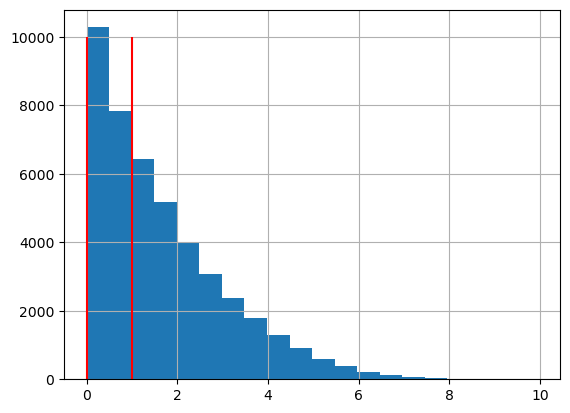

In [41]:
import matplotlib.pyplot as plt
TD_compare['RT_diff'].hist(bins=20)
TD_compare['RT_diff'].describe()
plt.vlines(x=[0, 1], ymax=10000, ymin=0, colors='r')